In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Ice Cream Producation Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
df_ice_cream = pd.read_csv('ice_cream.csv', 
                            parse_dates=[0], 
                            index_col=0, 
                            # squeeze=True, 
                            date_parser=parser)

#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

if df_ice_cream.shape[1] == 1:
    df_ice_cream = df_ice_cream.iloc[:, 0].squeeze()
else:
    df_ice_cream = df_ice_cream.squeeze()
    
df_ice_cream

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_2126/1156884190.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_ice_cream = pd.read_csv('ice_cream.csv',


DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [4]:
#infer the frequency of the data
df_ice_cream = df_ice_cream.asfreq(pd.infer_freq(df_ice_cream.index))
df_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [5]:
import plotly.express as px

fig = px.line(df_ice_cream)
fig.show()

In [6]:
start_date = datetime(2010,1,1)
selected_df_ice_cream = df_ice_cream[start_date:]
selected_df_ice_cream.shape

(121,)

In [7]:
import plotly.express as px

fig = px.line(selected_df_ice_cream)
fig.show()

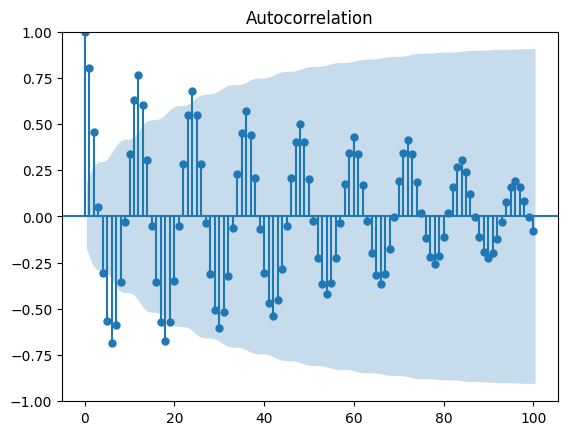

In [8]:
acf_plot = plot_acf(selected_df_ice_cream, lags=100)

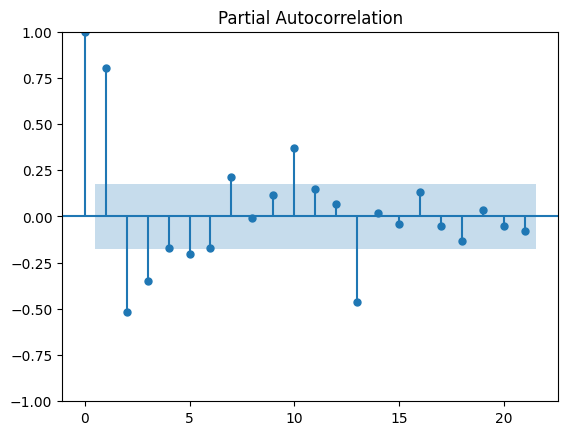

In [9]:
pacf_plot = plot_pacf(selected_df_ice_cream)

# Get training and testing data

In [10]:
train_end = datetime(2018, 12,1)
test_end = datetime(2019,12,1)

train_data = selected_df_ice_cream[:train_end]
test_data = selected_df_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR Model

In [12]:
# model = ARMA(train_data, order=(5,0))
model = ARIMA(train_data, order=(5,0,0))

start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.041465044021606445


In [13]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -369.467
Date:                Tue, 09 Sep 2025   AIC                            752.934
Time:                        17:31:14   BIC                            771.709
Sample:                    01-01-2010   HQIC                           760.547
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6182      1.373     75.490      0.000     100.928     106.308
ar.L1          0.9474      0.096      9.891      0.000       0.760       1.135
ar.L2         -0.1156      0.155     -0.747      0.4

In [ ]:
pred_start_date = test_end.index[0]
pred_end_date = test_end.index[-1]